# Load Data

In [ ]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 4.8 MB/s 
     |████████████████████████████████| 132 kB 24.8 MB/s 
     |████████████████████████████████| 79 kB 3.1 MB/s 
     |████████████████████████████████| 10.2 MB 67.8 MB/s 
     |████████████████████████████████| 140 kB 55.7 MB/s 
     |████████████████████████████████| 127 kB 49.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 1.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data

import os
from collections import Counter
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

data_dir = "/content/drive/MyDrive/Colab Notebooks/Capstone/data/gweb_sancl"
wsj_dir = os.path.join(data_dir, "pos_fine", "wsj")
model_dir = "/content/drive/MyDrive/Colab Notebooks/Capstone/model"
result_dir = "/content/drive/MyDrive/Colab Notebooks/Capstone/result"
plot_tags_dir = "/content/drive/MyDrive/Colab Notebooks/Capstone/plots_tags"

Mounted at /content/drive


In [ ]:
wsj_train_file = os.path.join(wsj_dir, "gweb-wsj-train.conll")
wsj_dev_file = os.path.join(wsj_dir, "gweb-wsj-dev.conll")
wsj_test_file = os.path.join(wsj_dir, "gweb-wsj-test.conll")

In [ ]:
wsj_train_word_lst, wsj_train_tag_lst, wsj_train_tag_set = read_data(wsj_train_file)
wsj_dev_word_lst, wsj_dev_tag_lst, wsj_dev_tag_set = read_data(wsj_dev_file)
wsj_test_word_lst, wsj_test_tag_lst, wsj_test_tag_set = read_data(wsj_test_file)

The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


In [ ]:
wsj_tags = wsj_train_tag_set + wsj_dev_tag_set + wsj_test_tag_set
wsj_tags = sorted(list(set(wsj_tags)))
wsj_tags = ["<pad>"] + wsj_tags
tag2idx = {tag:idx for idx, tag in enumerate(wsj_tags)}
idx2tag = {idx:tag for idx, tag in enumerate(wsj_tags)}
print(len(wsj_tags))

49


# Build Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

100%|██████████| 213450/213450 [00:00<00:00, 3447233.77B/s]


In [ ]:
class PosDataset(data.Dataset):
    def __init__(self, word_lst, tag_lst):
        sents, tags_li = [], [] # list of lists
        for i in range(len(word_lst)):
            sents.append(["[CLS]"] + word_lst[i] + ["[SEP]"])
            tags_li.append(["<pad>"] + tag_lst[i] + ["<pad>"])
        self.sents, self.tags_li = sents, tags_li

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, idx):
        words, tags = self.sents[idx], self.tags_li[idx] # words, tags: string list

        # We give credits only to the first piece.
        x, y = [], [] # list of ids
        is_heads = [] # list. 1: the token is the first piece of a word
        for w, t in zip(words, tags):
            tokens = tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = tokenizer.convert_tokens_to_ids(tokens)

            is_head = [1] + [0]*(len(tokens) - 1)

            t = [t] + ["<pad>"] * (len(tokens) - 1)  # <PAD>: no decision
            yy = [tag2idx[each] for each in t]  # (T,)

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)

        assert len(x)==len(y)==len(is_heads), "len(x)={}, len(y)={}, len(is_heads)={}".format(len(x), len(y), len(is_heads))

        # seqlen
        seqlen = len(y)

        # to string
        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen


In [ ]:
def pad(batch):
    '''Pads to the longest sample'''
    f = lambda x: [sample[x] for sample in batch]
    words = f(0)
    is_heads = f(2)
    tags = f(3)
    seqlens = f(-1)
    maxlen = np.array(seqlens).max()

    f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch] # 0: <pad>
    x = f(1, maxlen)
    y = f(-2, maxlen)


    f = torch.LongTensor

    return words, f(x), is_heads, tags, f(y), seqlens

In [ ]:
from pytorch_pretrained_bert import BertModel

In [ ]:
class Net(nn.Module):
    def __init__(self, vocab_size=None):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')

        self.fc = nn.Linear(768, vocab_size)
        self.device = device

    def forward(self, x, y):
        '''
        x: (N, T). int64
        y: (N, T). int64
        '''
        x = x.to(device)
        y = y.to(device)
        
        if self.training:
            self.bert.train()
            encoded_layers, _ = self.bert(x)
            enc = encoded_layers[-1]
        else:
            self.bert.eval()
            with torch.no_grad():
                encoded_layers, _ = self.bert(x)
                enc = encoded_layers[-1]
        
        logits = self.fc(enc)
        y_hat = logits.argmax(-1)
        return logits, y, y_hat

In [ ]:
def train(model, iterator, optimizer, criterion):
    model.train()
    for i, batch in enumerate(iterator):
        words, x, is_heads, tags, y, seqlens = batch
        _y = y # for monitoring
        optimizer.zero_grad()
        logits, y, _ = model(x, y) # logits: (N, T, VOCAB), y: (N, T)

        logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
        y = y.view(-1)  # (N*T,)

        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()

        if i%10==0: # monitoring
            print("step: {}, loss: {}".format(i, loss.item()))

In [ ]:
def eval(model, iterator, save_output=True, output_file=None, average="weighted"):
    model.eval()

    Words, Is_heads, Tags, Y, Y_hat = [], [], [], [], []

    pred_lst = []
    true_lst = []

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words, x, is_heads, tags, y, seqlens = batch

            _, _, y_hat = model(x, y)  # y_hat: (N, T)

            for s in y_hat.cpu().numpy().tolist():
              pred_lst.extend(s)
            for s in y.numpy().tolist():
              true_lst.extend(s)

            if save_output:
              Words.extend(words)
              Is_heads.extend(is_heads)
              Tags.extend(tags)
              Y.extend(y.numpy().tolist())
              Y_hat.extend(y_hat.cpu().numpy().tolist())

    ## gets results and save
    if save_output:
      with open(output_file, 'w') as fout:
          for words, is_heads, tags, y_hat in zip(Words, Is_heads, Tags, Y_hat):
              y_hat = [hat for head, hat in zip(is_heads, y_hat) if head == 1]
              preds = [idx2tag[hat] for hat in y_hat]
              assert len(preds)==len(words.split())==len(tags.split())
              for w, t, p in zip(words.split()[1:-1], tags.split()[1:-1], preds[1:-1]):
                  fout.write("{} {} {}\n".format(w, t, p))
              fout.write("\n")
            
    # ## calc metric
    # y_true =  np.array([tag2idx[line.split()[1]] for line in open('result', 'r').read().splitlines() if len(line) > 0])
    # y_pred =  np.array([tag2idx[line.split()[2]] for line in open('result', 'r').read().splitlines() if len(line) > 0])


    precision_value = multiclass_precision(
            torch.tensor(pred_lst), torch.tensor(true_lst), num_classes=len(wsj_tags), ignore_index=0, 
            average=average)   
    recall_value = multiclass_recall(
            torch.tensor(pred_lst), torch.tensor(true_lst), num_classes=len(wsj_tags), ignore_index=0, 
            average=average)   
    f1_value = multiclass_f1_score(
            torch.tensor(pred_lst), torch.tensor(true_lst), num_classes=len(wsj_tags), ignore_index=0, 
            average=average)   
    acc = multiclass_accuracy(
        torch.tensor(pred_lst), torch.tensor(true_lst), num_classes=len(wsj_tags), ignore_index=0, 
        average=average)    


    return precision_value, recall_value, f1_value, acc

In [ ]:
model = Net(vocab_size=len(tag2idx))
model.to(device)
model = nn.DataParallel(model)

100%|██████████| 404400730/404400730 [00:13<00:00, 30893227.71B/s]


In [ ]:
train_dataset = PosDataset(wsj_train_word_lst, wsj_train_tag_lst)
eval_dataset = PosDataset(wsj_test_word_lst, wsj_test_tag_lst)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
test_iter = data.DataLoader(dataset=eval_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
# train(model, train_iter, optimizer, criterion)
# eval(model, test_iter)

# Save Model

In [ ]:
model_file = os.path.join(model_dir, "base_model.pt")
# torch.save(model.state_dict(), model_file)

## Load Model

In [ ]:
model = Net(vocab_size=len(tag2idx))
model.to(device)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(model_file))
wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value = eval(model, test_iter, save_output=False)
print(wsj_precision_value, wsj_recall_value, wsj_f1_value, wsj_acc_value)

tensor(0.9771) tensor(0.9743) tensor(0.9751) tensor(0.9743)


# Self Training

In [ ]:
def filter_tag(process_words, process_tags, label_tags_set=wsj_tags):
  new_words = []
  new_tags = []
  for words, tags in zip(process_words, process_tags):
    w_lst = []
    t_lst = []
    for i, t in enumerate(tags):
      if t in label_tags_set:
        w_lst.append(words[i])
        t_lst.append(tags[i])

    if w_lst:
      new_words.append(w_lst)
      new_tags.append(t_lst)
  print("after filter tag", len(new_words))
  return new_words, new_tags

In [ ]:
file_name_lst = ["answers", "emails", "newsgroups", "reviews", "weblogs"]

In [ ]:
domain = "emails"
domain_dir = os.path.join(data_dir, "pos_fine", f"{domain}")
domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

In [ ]:
domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)
domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

The number of samples: 2450
The number of tags 49
The number of samples: 2450
The number of tags 48
after filter tag 2427
after filter tag 2402


In [ ]:
# create dir
sub_result_dir = os.path.join(result_dir, "Online_fixed_self_learning", domain)
if not os.path.isdir(sub_result_dir):
  os.makedirs(sub_result_dir)

sub_plots_tags_dir = os.path.join(plot_tags_dir, "Online_fixed_self_learning", domain)
if not os.path.isdir(sub_plots_tags_dir):
  os.makedirs(sub_plots_tags_dir)

In [ ]:
class PosDataset_new(data.Dataset):
    def __init__(self, word_lst, tag_lst):
        self.word_lst, self.tag_lst = word_lst, tag_lst

    def __len__(self):
      return len(self.word_lst)

    def __getitem__(self, idx):
      words, tags = self.word_lst[idx], self.tag_lst[idx] # words, tags: string list
      assert len(words)==len(tags)
        # seqlen
      seqlen = len(words)

      return words, tags, seqlen

def pad_new(batch):
    '''Pads to the longest sample'''
    f = lambda x: [sample[x] for sample in batch]
    words = f(0)
    tags = f(1)
    seqlens = f(-1)
    maxlen = np.array(seqlens).max()

    f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch] # 0: <pad>
    x = f(0, maxlen)
    y = f(1, maxlen)

    f = torch.LongTensor

    return f(x), f(y), seqlens

def train_new(model, iterator, optimizer, criterion):
    model.train()
    for i, batch in enumerate(iterator):
        x, y, seqlens = batch
        
        optimizer.zero_grad()
        logits, y, _ = model(x, y) # logits: (N, T, VOCAB), y: (N, T)

        logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
        y = y.view(-1)  # (N*T,)

        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()

        if i%10==0: # monitoring
            print("step: {}, loss: {}".format(i, loss.item()))


def gen_pseudo_data(model, domain_dev_iter, topn=300, initial=True):
  model.eval()

  LLD = []
  MEAN_PROB = []
  new_x_lst = []
  new_y_lst = []
  acc_lst = []

  if initial:
    with torch.no_grad():
        for i, batch in enumerate(domain_dev_iter):

          _, x, _, _, y, _ = batch
          # When calculating the length of sentences, ignore <pad>
          sen_len = y.bool().sum(axis=1)

          logits, _, y_hat = model(x, y)  # y_hat: (N, T)

          # Save prediction as new training dataset
          softmax_value = torch.softmax(logits, dim=2)
          max_prob = torch.amax(softmax_value, dim=2)

          # Rank by mean probability
          res_prob = y.bool().to(device) * max_prob.to(device)
          sum_prob = res_prob.sum(axis=1)
          mean_prob = sum_prob / sen_len.to(device)
          MEAN_PROB.extend(mean_prob.tolist())
          
          new_x_lst.extend(x.tolist())
          new_y_lst.extend(y_hat.tolist())

          # Calculate the accuracy for each sentences, ignore 0
          batch_acc = multiclass_accuracy(
              torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags), 
              ignore_index=0, average="micro", multidim_average="samplewise")
          acc_lst.extend(batch_acc.tolist())
          

  else:
    with torch.no_grad():
        for i, batch in enumerate(domain_dev_iter):

          x, y, seqlens = batch
          sen_len = y.bool().sum(axis=1)

          logits, _, y_hat = model(x, y)  # y_hat: (N, T)

          # Save prediction as new training dataset
          softmax_value = torch.softmax(logits, dim=2)
          max_prob = torch.amax(softmax_value, dim=2)

          # Rank by mean probability
          res_prob = y.bool().to(device) * max_prob.to(device)
          sum_prob = res_prob.sum(axis=1)
          mean_prob = sum_prob / sen_len.to(device)
          MEAN_PROB.extend(mean_prob.tolist())
          
          new_x_lst.extend(x.tolist())
          new_y_lst.extend(y_hat.tolist())

          # Calculate the accuracy for each sentences, ignore 0
          batch_acc = multiclass_accuracy(
              torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags), 
              ignore_index=0, average="micro", multidim_average="samplewise")
          acc_lst.extend(batch_acc.tolist())

  ind = list(range(len(MEAN_PROB)))
  ind = [x for _, x in sorted(zip(MEAN_PROB, ind), reverse=True)]
  prob_lst = [prob for prob, _ in sorted(zip(MEAN_PROB, ind), reverse=True)]

  select_ind = ind[: topn] # The index of topn sentences
  not_select_ind = ind[topn: ]

  new_train_x = [new_x_lst[i] for i in select_ind]
  new_train_y = [new_y_lst[i] for i in select_ind]

  remain_train_x = [new_x_lst[i] for i in not_select_ind]
  remain_train_y = [new_y_lst[i] for i in not_select_ind]

  new_prob = prob_lst[: topn]
  remain_prob = prob_lst[topn: ]
  new_acc = [acc_lst[i] for i in select_ind]
  remain_acc = [acc_lst[i] for i in not_select_ind]


  return new_train_x, new_train_y, remain_train_x, remain_train_y, new_acc, remain_acc, new_prob, remain_prob

In [ ]:
def save_sns_fig(each_class_df, output_plot_file):

  fig = plt.figure(figsize=(20,6))

  p1 = sns.scatterplot(
      data=each_class_df, x="POS_tags", y="acc",
      size = 8,
      legend=False)  

  for line in range(0, each_class_df.shape[0]):
      p1.text(
          each_class_df.POS_tags[line], each_class_df.acc[line], 
          round(each_class_df.acc[line], 3), horizontalalignment='left', 
          size='small', color='black', weight='semibold')

  sns.lineplot(data=each_class_df, x="POS_tags", y="acc")
  sns.scatterplot(data=each_class_df, x="POS_tags", y="acc")
  plt.xticks(rotation=45, size=10)

  ax2 = plt.twinx()
  sns.barplot(data=each_class_df, x="POS_tags", y="cnt", alpha=0.5, ax=ax2)

  fig.savefig(output_plot_file) 
  

def save_plotly_fig(each_class_df, output_plot_file):

  # Create figure with secondary y-axis
  fig = make_subplots(specs=[[{"secondary_y": True}]])

  # Add traces
  fig.add_trace(
      go.Bar(
          x=each_class_df["POS_tags"], y=each_class_df["cnt"], 
          name="count", opacity=0.5),
      secondary_y=True,
  )

  fig.add_trace(
      go.Scatter(
          x=each_class_df["POS_tags"], y=each_class_df["acc"], 
          mode='markers+lines', name="accuracy"),
      secondary_y=False,
  )

  # Add figure title
  fig.update_layout(
      title_text="Double Y Axis Example"
  )

  # Set x-axis title
  fig.update_xaxes(title_text="xaxis title")

  # Set y-axes titles
  fig.update_yaxes(title_text="<b>Accuracy</b>", secondary_y=False)
  fig.update_yaxes(title_text="<b>The number of tags</b>", secondary_y=True)
  fig.write_image(output_plot_file)


def analysis_output(output_res_file, csvsave=False, pngsave=False, csv_file_name=None, output_plot_name=None):

  y_true =  np.array([tag2idx[line.split()[1]] for line in open(output_res_file, 'r').read().splitlines() if len(line) > 0])
  y_pred =  np.array([tag2idx[line.split()[2]] for line in open(output_res_file, 'r').read().splitlines() if len(line) > 0])

  y_true_tensor = torch.from_numpy(y_true)
  y_pred_tensor = torch.from_numpy(y_pred)

  each_class_acc = multiclass_accuracy(
      torch.tensor(y_pred).to(device), 
      torch.tensor(y_true).to(device), 
      num_classes=len(wsj_tags), 
      ignore_index=0, average=None)

  each_class_acc_lst = each_class_acc.tolist()

  each_class_df = pd.DataFrame.from_dict(Counter(y_true), orient='index').reset_index()
  each_class_df.columns = ["POS_id", "cnt"]
  each_class_df = each_class_df.sort_values(by="POS_id").reset_index(drop=True)
  each_class_df["acc"] = each_class_df["POS_id"].apply(lambda x: each_class_acc_lst[x])
  each_class_df["POS_tags"] = each_class_df["POS_id"].apply(lambda x: idx2tag[x])

  if csvsave:
    each_class_df.to_csv(csv_file_name, index=False)
  if pngsave:
    save_sns_fig(each_class_df, output_plot_name)

  return each_class_df

In [ ]:
domain_precision_value_lst = []
domain_recall_value_lst = []
domain_f1_value_lst = []
domain_acc_value_lst = []

In [ ]:
loop_i = 0
top_percent = 0.05

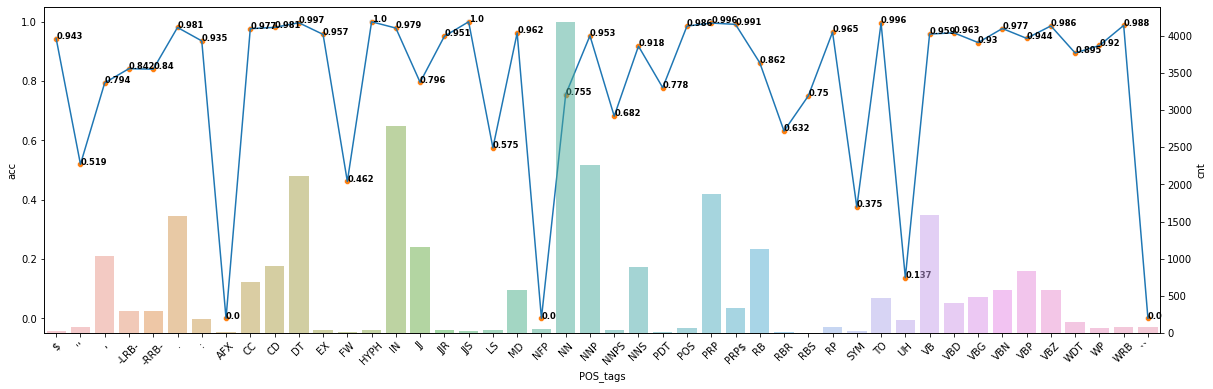

In [ ]:
domain_test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

domain_test_iter = data.DataLoader(dataset=domain_test_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

output_res_file = os.path.join(sub_result_dir, f"{top_percent}-loop{loop_i}.txt")
domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.csv")
output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.png")
_ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)

domain_precision_value_lst.append(domain_precision_value)
domain_recall_value_lst.append(domain_recall_value)
domain_f1_value_lst.append(domain_f1_value)
domain_acc_value_lst.append(domain_acc_value)


Loop 1
domain_dev_word_lst 2427


<ipython-input-24-e4cd7dac7ad5>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.33425232768058777
step: 10, loss: 0.07435792684555054

Loop 2
domain_dev_word_lst 2306


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.0035505874548107386
step: 10, loss: 0.0011240271851420403

Loop 3
domain_dev_word_lst 2185


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.0003105023643001914
step: 10, loss: 0.00023042877728585154

Loop 4
domain_dev_word_lst 2064


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.0008924157009460032
step: 10, loss: 0.0059294672682881355

Loop 5
domain_dev_word_lst 1943


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.003995793871581554
step: 10, loss: 0.000787301454693079

Loop 6
domain_dev_word_lst 1822


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.0033519763965159655
step: 10, loss: 0.002838672837242484

Loop 7
domain_dev_word_lst 1701


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.0067417211830616
step: 10, loss: 0.00031215473427437246

Loop 8
domain_dev_word_lst 1580


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.00045253863208927214
step: 10, loss: 0.0004295170947443694

Loop 9
domain_dev_word_lst 1459


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.000808737997431308
step: 10, loss: 0.0007589174783788621

Loop 10
domain_dev_word_lst 1338


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.0012375789228826761
step: 10, loss: 0.004746576771140099

Loop 11
domain_dev_word_lst 1217


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.010585509240627289
step: 10, loss: 0.001742745516821742

Loop 12
domain_dev_word_lst 1096


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.0012651884462684393
step: 10, loss: 0.002476086840033531

Loop 13
domain_dev_word_lst 975


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.007754204794764519
step: 10, loss: 0.0013179292436689138

Loop 14
domain_dev_word_lst 854


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.002214687643572688
step: 10, loss: 0.006893486250191927

Loop 15
domain_dev_word_lst 733


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.0027278654742985964
step: 10, loss: 0.005526671186089516

Loop 16
domain_dev_word_lst 612


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.007935279048979282
step: 10, loss: 0.005495721474289894

Loop 17
domain_dev_word_lst 491


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.0075047858990728855
step: 10, loss: 0.0036001764237880707

Loop 18
domain_dev_word_lst 370


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.013087562285363674
step: 10, loss: 0.00766712985932827

Loop 19
domain_dev_word_lst 249


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.018642477691173553
step: 10, loss: 0.014734222553670406

Loop 20
domain_dev_word_lst 128


<ipython-input-24-e4cd7dac7ad5>:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_hat).to(device), torch.tensor(y).to(device), num_classes=len(wsj_tags),


step: 0, loss: 0.07582426071166992
step: 10, loss: 0.02452312968671322


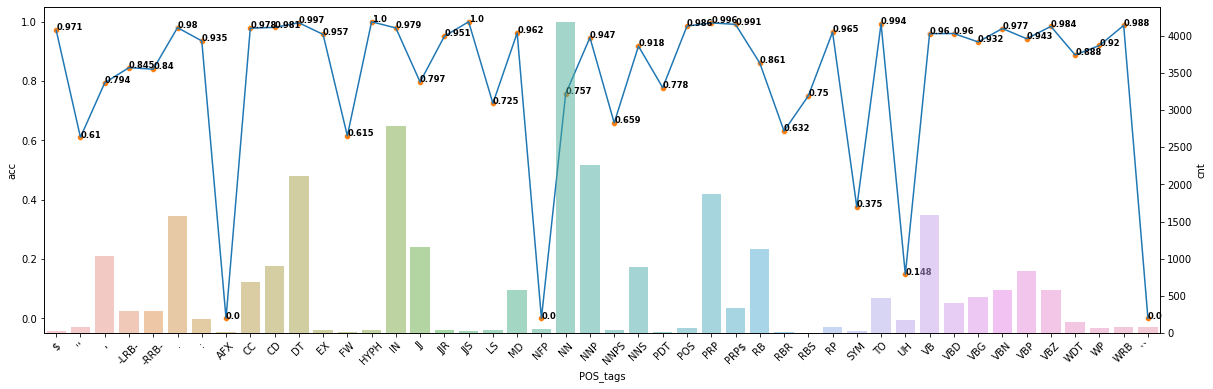

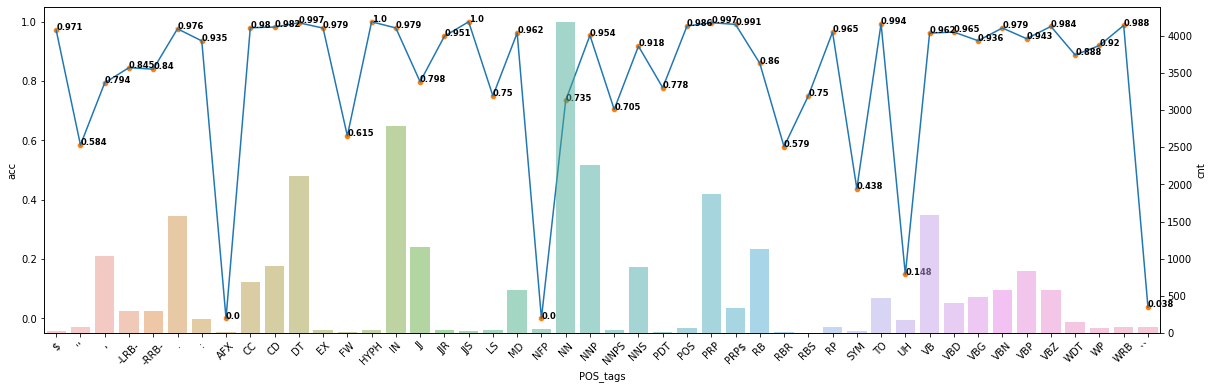

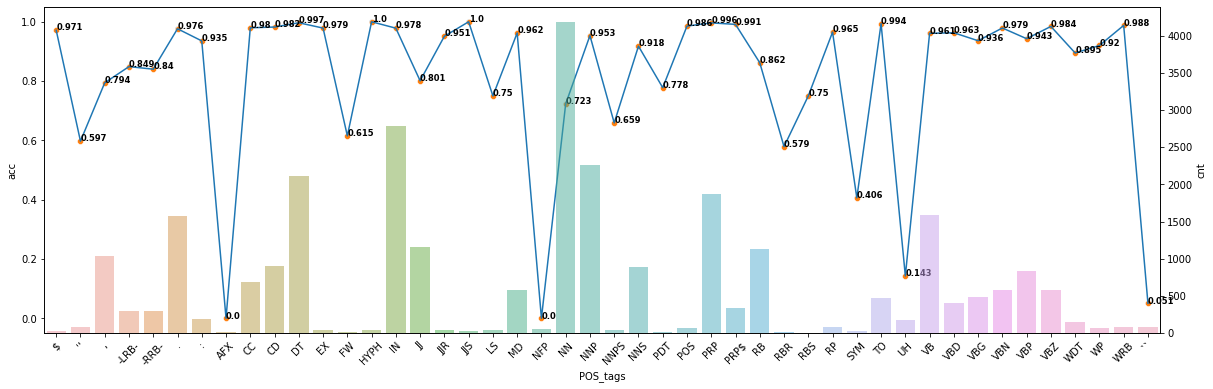

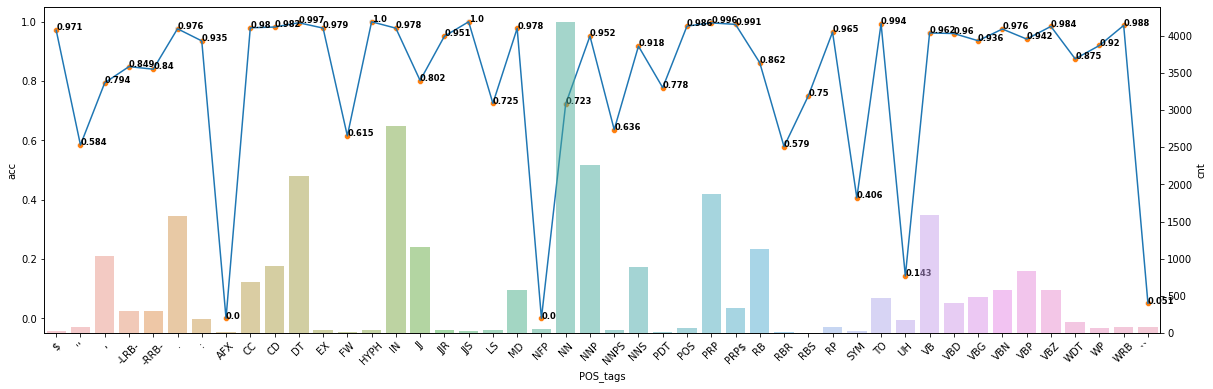

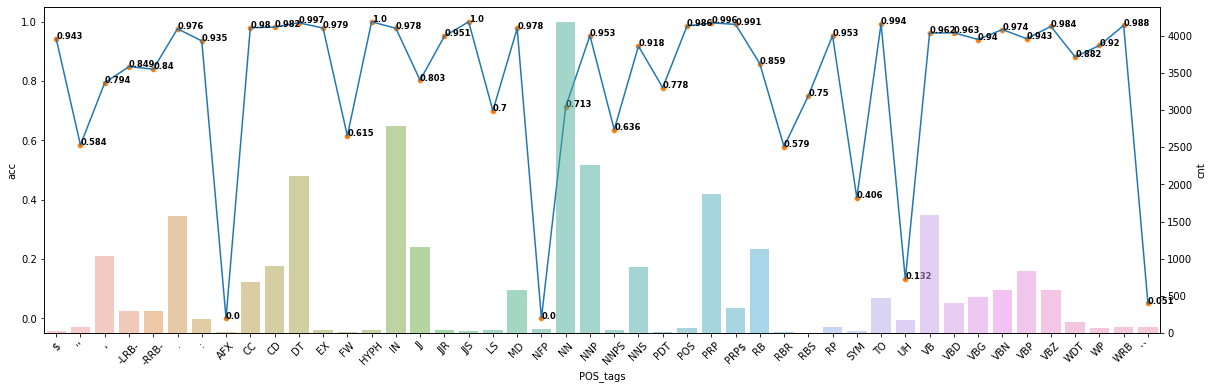

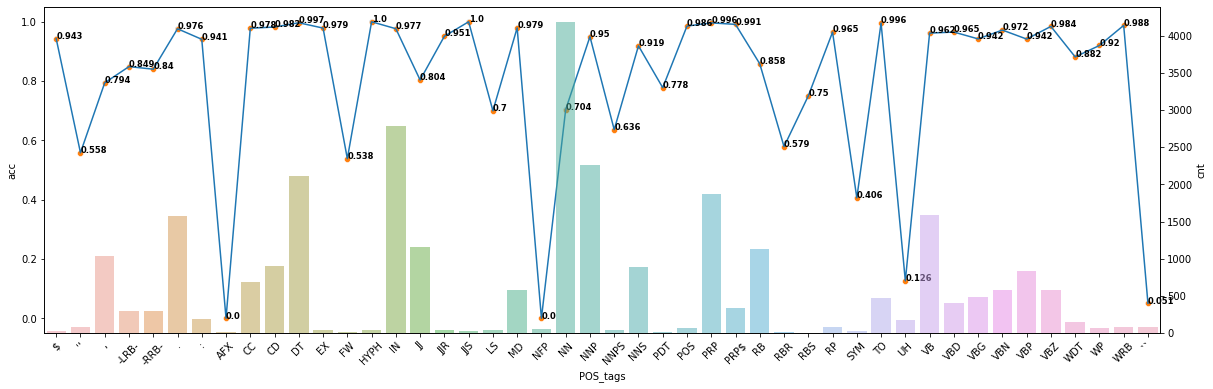

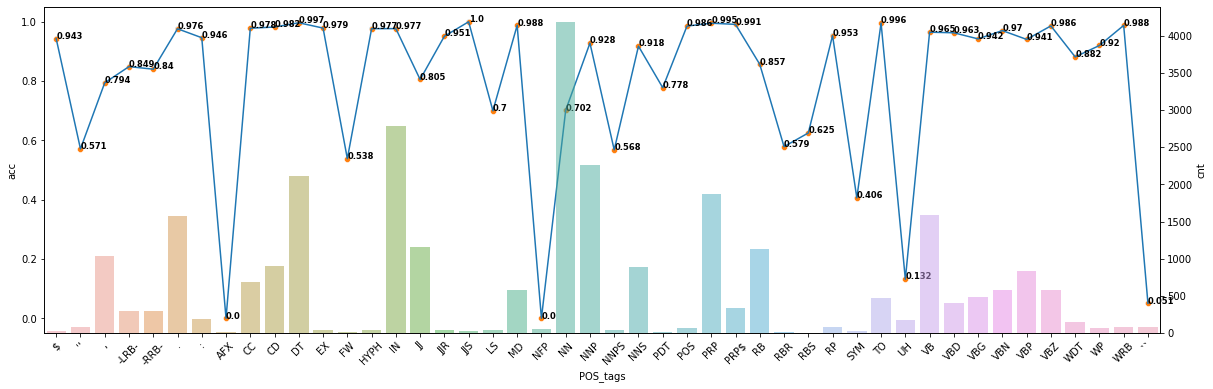

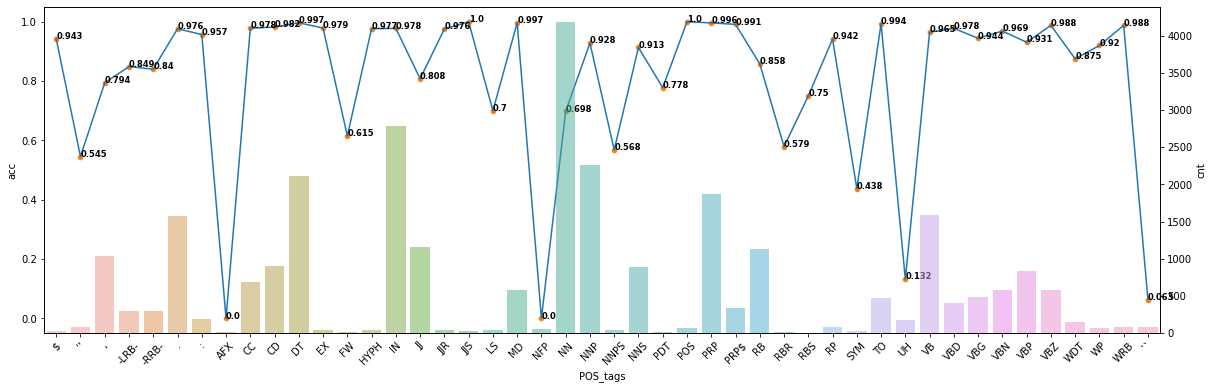

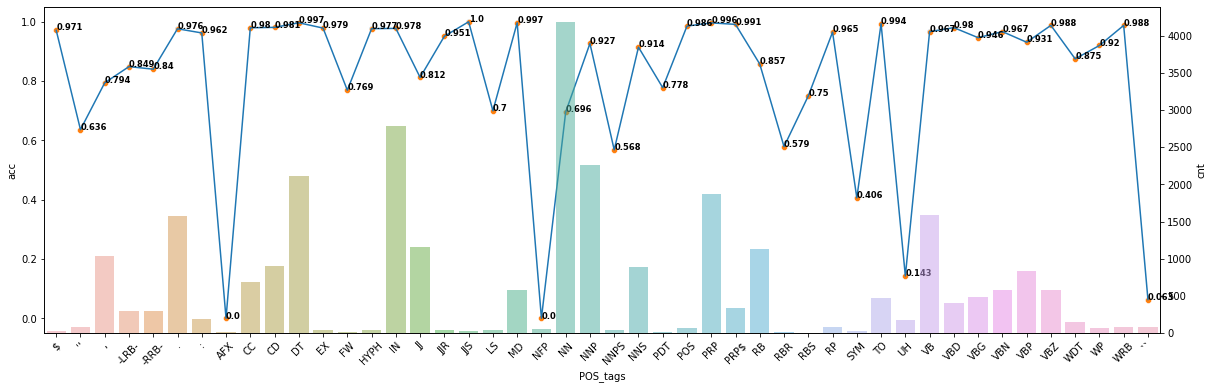

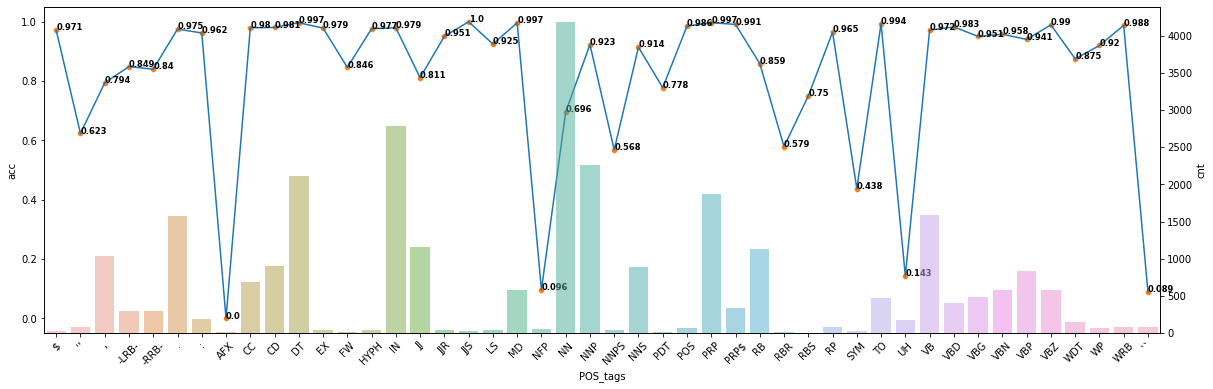

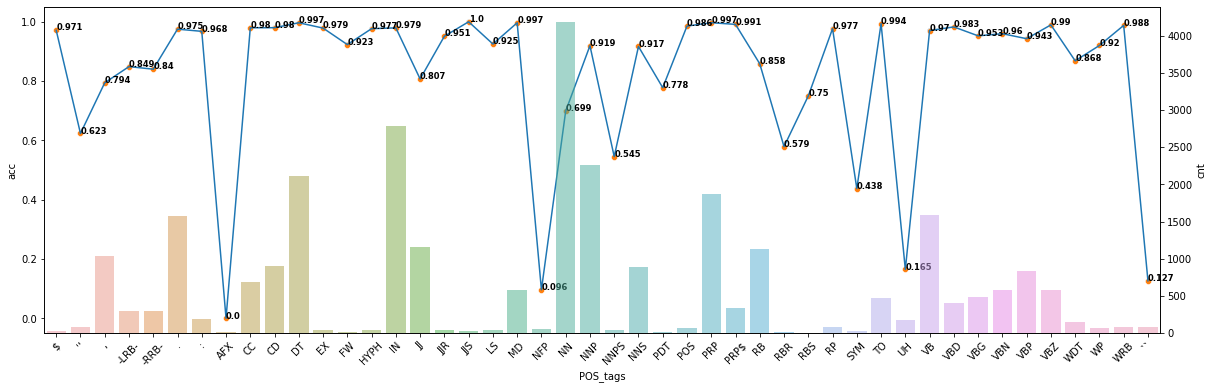

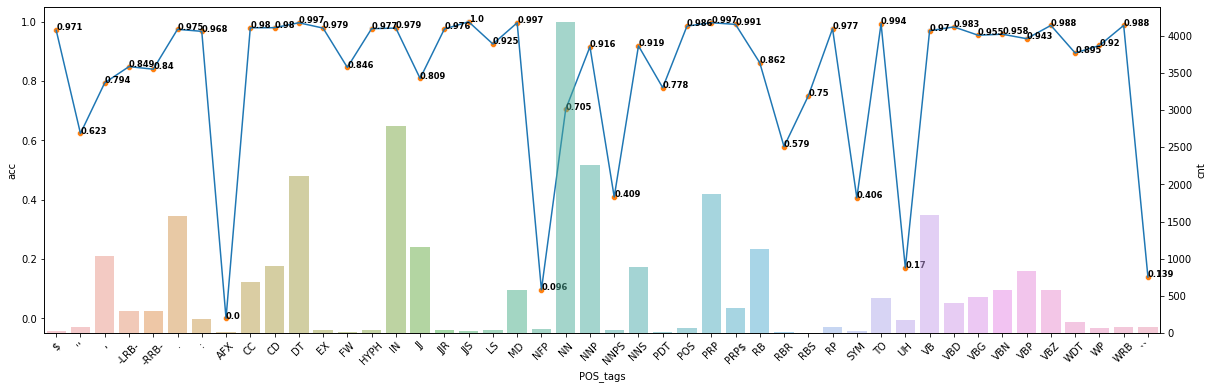

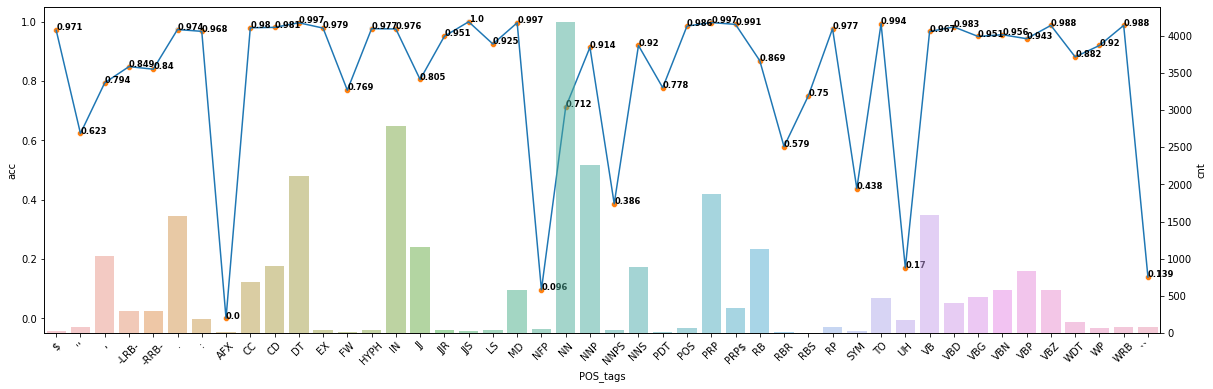

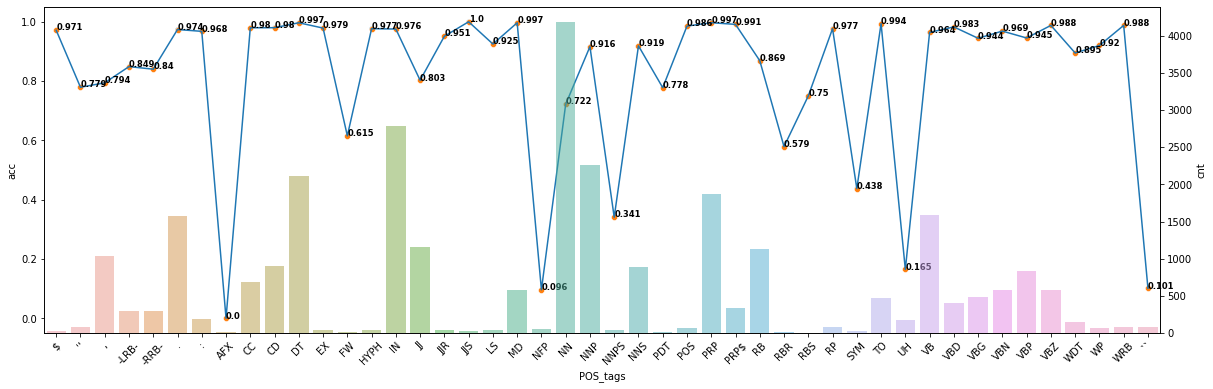

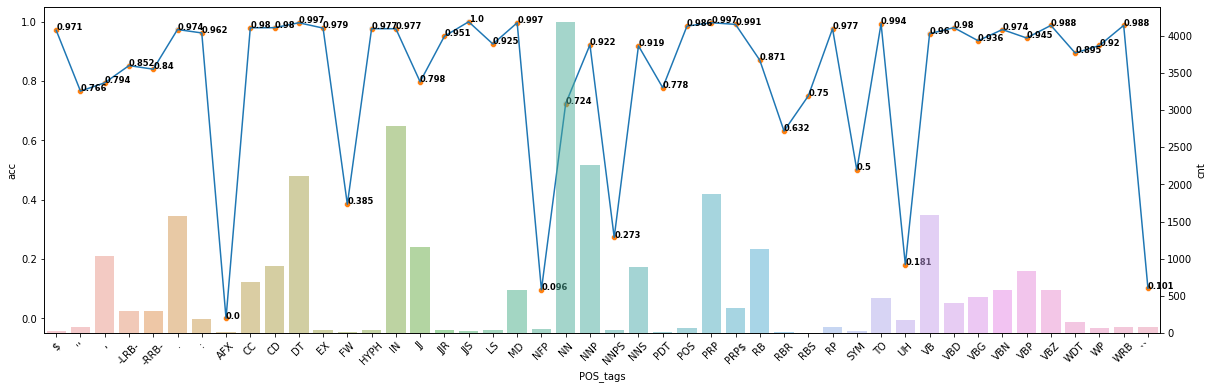

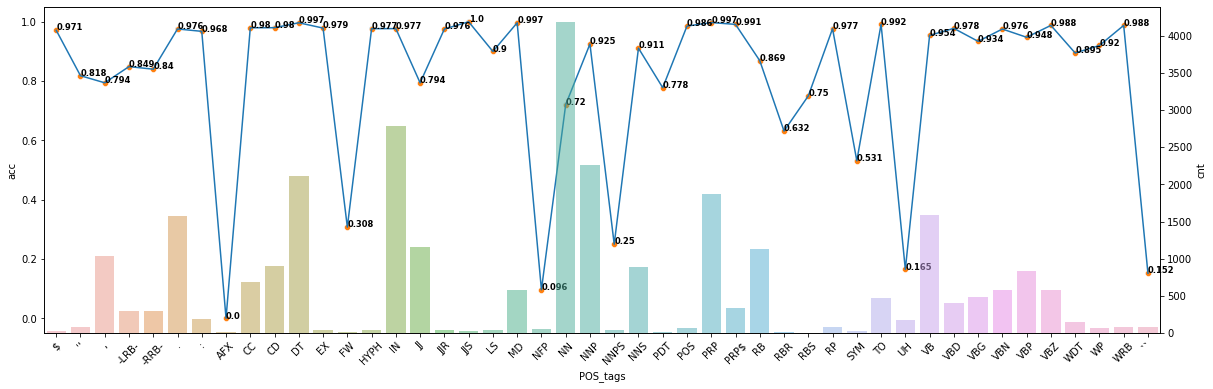

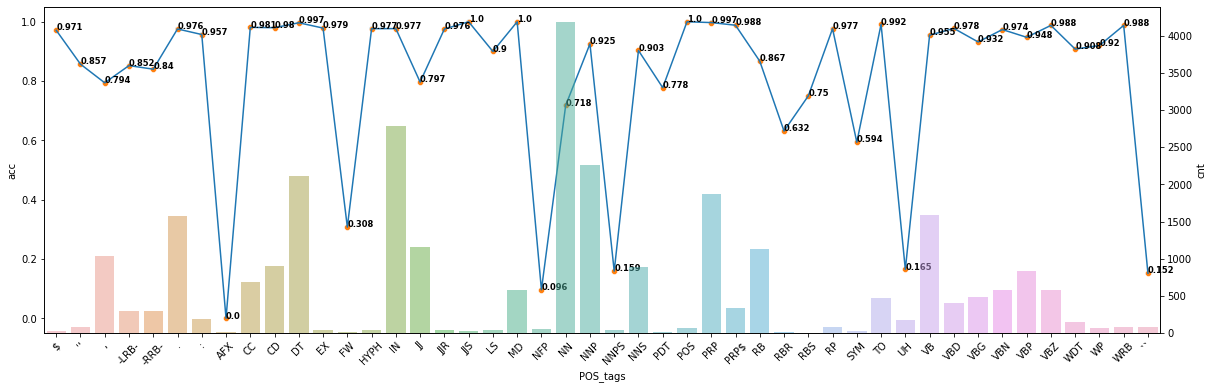

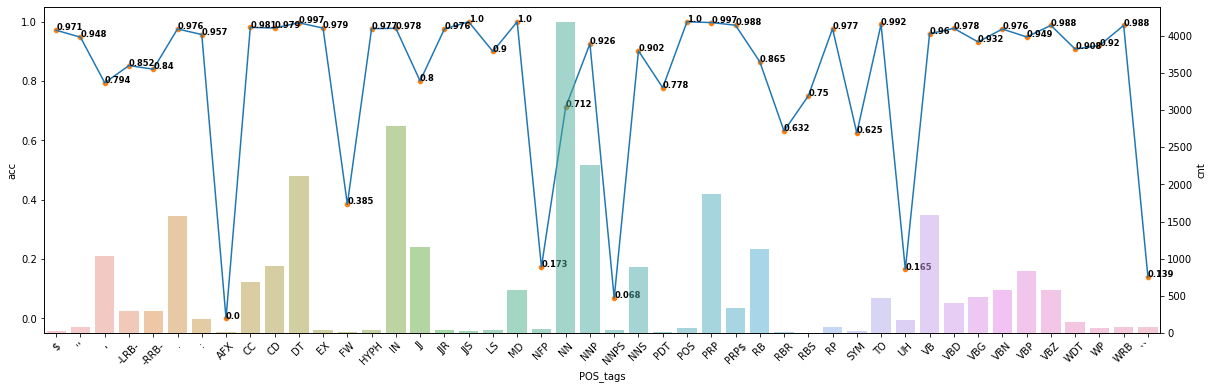

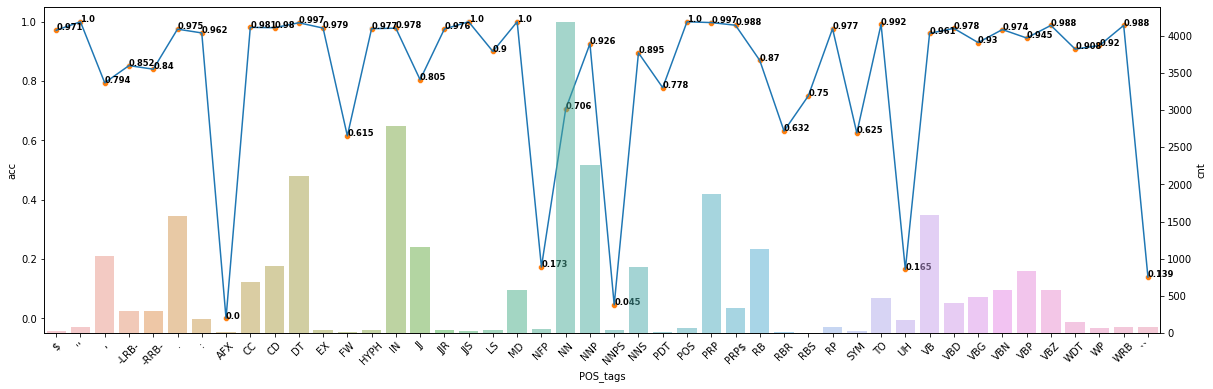

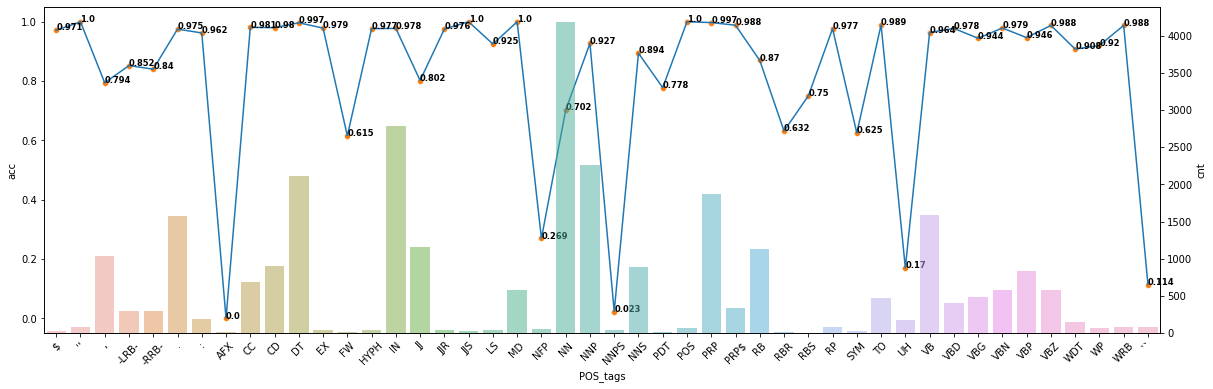

In [ ]:
acc_lst = []
prob_lst = []

topn = int(top_percent * len(domain_dev_word_lst))

while len(domain_dev_word_lst) >= topn:
  loop_i += 1
  print("\nLoop", loop_i)
  print("domain_dev_word_lst", len(domain_dev_word_lst))

  if loop_i == 1:
    domain_dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)

    domain_dev_iter = data.DataLoader(dataset=domain_dev_dataset,
                                batch_size=8,
                                shuffle=False,
                                num_workers=1,
                                collate_fn=pad)
  else:
    domain_dev_dataset = PosDataset_new(domain_dev_word_lst, domain_dev_tag_lst)

    domain_dev_iter = data.DataLoader(dataset=domain_dev_dataset,
                                batch_size=8,
                                shuffle=True,
                                num_workers=1,
                                collate_fn=pad_new)
    
  initial = True if loop_i==1 else False
  new_train_x, new_train_y, domain_dev_word_lst, domain_dev_tag_lst, new_acc, remain_acc, new_prob, remain_prob = gen_pseudo_data(model, domain_dev_iter, topn, initial)

  new_train_dataset = PosDataset_new(new_train_x, new_train_y)

  new_train_iter = data.DataLoader(dataset=new_train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=1,
                              collate_fn=pad_new)

  optimizer = optim.Adam(model.parameters(), lr = 0.00001)
  criterion = nn.CrossEntropyLoss(ignore_index=0)

  train_new(model, new_train_iter, optimizer, criterion)

  output_res_file = os.path.join(sub_result_dir, f"top{top_percent}-loop{loop_i}.txt")
  domain_precision_value, domain_recall_value, domain_f1_value, domain_acc_value = eval(model, domain_test_iter, save_output=True, output_file=output_res_file)

  domain_precision_value_lst.append(domain_precision_value)
  domain_recall_value_lst.append(domain_recall_value)
  domain_f1_value_lst.append(domain_f1_value)
  domain_acc_value_lst.append(domain_acc_value)

  acc_lst.append(new_acc)
  prob_lst.append(new_prob)

  csv_file_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.csv")
  output_plot_name = os.path.join(sub_plots_tags_dir, f"top{top_percent}-loop{loop_i}.png")
  _ = analysis_output(output_res_file, csvsave=True, pngsave=True, csv_file_name=csv_file_name, output_plot_name=output_plot_name)


In [ ]:
# acc_df = pd.DataFrame()
# for i in range(len(acc_lst)):
#   acc_df[f"Loop{i}"] = acc_lst[i]

# prob_df = pd.DataFrame()
# for i in range(len(prob_lst)):
#   prob_df[f"Loop{i}"] = prob_lst[i]

In [ ]:
print(domain_precision_value_lst)
print(domain_recall_value_lst)
print(domain_f1_value_lst)
print(domain_acc_value_lst)

print(acc_lst)
print(prob_lst)

[tensor(0.9122), tensor(0.9125), tensor(0.9132), tensor(0.9130), tensor(0.9134), tensor(0.9129), tensor(0.9133), tensor(0.9140), tensor(0.9150), tensor(0.9150), tensor(0.9172), tensor(0.9194), tensor(0.9196), tensor(0.9194), tensor(0.9199), tensor(0.9199), tensor(0.9196), tensor(0.9196), tensor(0.9200), tensor(0.9213), tensor(0.9214)]
[tensor(0.9051), tensor(0.9056), tensor(0.9033), tensor(0.9015), tensor(0.9014), tensor(0.9000), tensor(0.8982), tensor(0.8962), tensor(0.8961), tensor(0.8964), tensor(0.8974), tensor(0.8977), tensor(0.8984), tensor(0.8989), tensor(0.9005), tensor(0.9009), tensor(0.9002), tensor(0.8998), tensor(0.8997), tensor(0.8990), tensor(0.8990)]
[tensor(0.9023), tensor(0.9033), tensor(0.9015), tensor(0.9001), tensor(0.9002), tensor(0.8988), tensor(0.8974), tensor(0.8966), tensor(0.8967), tensor(0.8970), tensor(0.8985), tensor(0.9005), tensor(0.9013), tensor(0.9018), tensor(0.9033), tensor(0.9036), tensor(0.9027), tensor(0.9023), tensor(0.9022), tensor(0.9017), tenso

In [ ]:
import pandas as pd

In [ ]:
test_metric = pd.DataFrame({
    "Loop": list(range(len(domain_precision_value_lst))) * 3,
    "metric": ["precision"]*len(domain_precision_value_lst) + ["recall"]*len(domain_precision_value_lst) + ["f1"]*len(domain_precision_value_lst),
    "value": domain_precision_value_lst + domain_recall_value_lst + domain_f1_value_lst
})

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = px.line(test_metric, x="Loop", y="value", color='metric', markers=True)
fig.show()